In [1]:
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import (make_blobs, make_circles, make_moons)
import pickle
from scipy.ndimage import label
from sklearn.preprocessing import MinMaxScaler

In [2]:
import matplotlib
import sklearn
import scipy

In [3]:
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(scipy.__version__)

1.23.2
3.5.3
1.1.2
1.9.0


In [4]:
data1 = make_circles(factor=0.5, random_state=42, noise=0.05, n_samples=500)[0]
data2 = make_moons(n_samples=500, random_state=42, noise=0.05)[0]
data3 = make_blobs(n_samples=500, random_state=42, cluster_std=2)[0]
scaler = MinMaxScaler(feature_range=(0, 1))
if len(data1.shape) == 1:
    data1 = data1.reshape(-1, 1)
data1 = scaler.fit_transform(data1)
if len(data2.shape) == 1:
    data2 = data2.reshape(-1, 1)
data2 = scaler.fit_transform(data2)
if len(data3.shape) == 1:
    data3 = data3.reshape(-1, 1)
data3 = scaler.fit_transform(data3)

In [5]:
grid = 400

In [6]:
def count_local_maxs(data, s, grid=400):
    x = np.linspace(0, 1, grid+1)
    y = np.linspace(0, 1, grid+1)
    x, y = np.meshgrid(x, y)

    z = np.zeros_like(x)
    for point in data:
        z += gaussian(x, y, point[0], point[1], s)

    delta = [[-1, 0], [1, 0], [0, -1], [0, 1]]

    local_maxs = 0

    for i in range(grid+1):
        for j in range(grid+1):
            flag = 1
            for d in delta:
                if 0 <= i+d[0] < grid+1 and 0 <= j+d[1] < grid+1:
                    if z[i+d[0], j+d[1]] > z[i, j]:
                        flag = 0
                        break
            if flag:
                local_maxs += 1

    return local_maxs

In [ ]:
# s_list = np.linspace(0.01, 0.5, 30)
# maxcnt_1 = []
# maxcnt_2 = []
# maxcnt_3 = []
# for s in s_list:
#     maxcnt_1.append(count_local_maxs(data1, s, grid))
#     maxcnt_2.append(count_local_maxs(data2, s, grid))
#     maxcnt_3.append(count_local_maxs(data3, s, grid))

In [8]:
import pickle

data = {
    'maxcnt_1': maxcnt_1,
    'maxcnt_2': maxcnt_2,
    'maxcnt_3': maxcnt_3,
    'maxcnt_4': maxcnt_4
}

# Specify the file path to save the pickle file
file_path = 'maxcnt_variables.pkl'

# Save the variables as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(data, file)

In [ ]:
k = [2, 2, 3]
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.plot(s_list, data[f'maxcnt_{i+1}'], label=f'data{i+1}')
    plt.plot(s_list, k[i]*np.ones_like(s_list), label=f'k={k[i]}')
    plt.grid()
    plt.xlabel('s')
    plt.ylabel('Number of local maxima')
    plt.title(f'data{i+1}')
    plt.legend()
plt.show()

In [10]:
s_det = [0.02, 0.1, 0.05]

In [11]:
data_list = [data1, data2, data3]

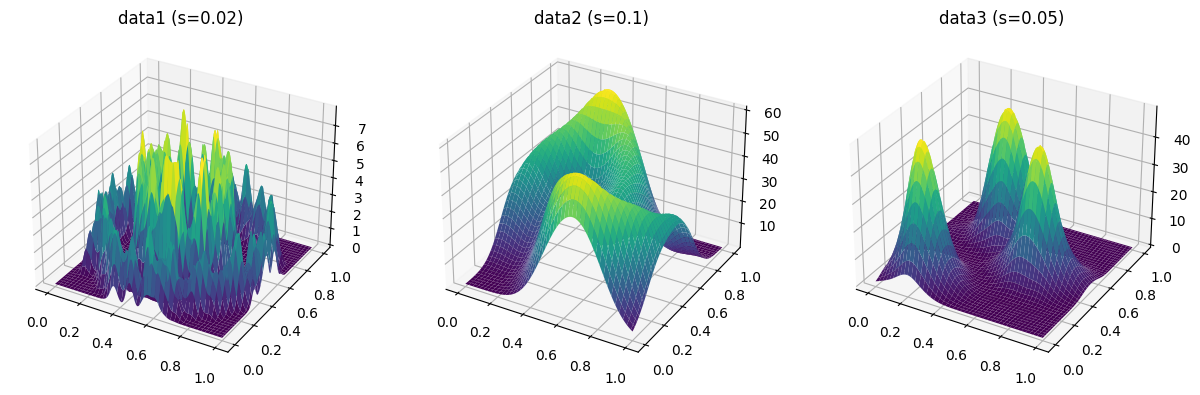

In [12]:
grid = 400
sub_list = [131, 132, 133]
s_det = [0.02, 0.1, 0.05]
title_list = [f'data1 (s={s_det[0]})', f'data2 (s={s_det[1]})', f'data3 (s={s_det[2]})']

fig = plt.figure(figsize=(15, 5))

for i in range(3):
    data = data_list[i]
    s = s_det[i]
    title = title_list[i]
    x = np.linspace(0, 1, grid+1)
    y = np.linspace(0, 1, grid+1)
    x, y = np.meshgrid(x, y)

    z = np.zeros_like(x)
    for point in data:
        z += gaussian(x, y, point[0], point[1], s)

    ax = fig.add_subplot(sub_list[i], projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none')
    ax.set_title(title)

plt.show()

In [13]:
def simul_edge_custom(data, lim, grid, ball, sigma, hill_method=0, k=2): # grid//ball should be int
    X = data
    xlim, ylim = lim
    x = np.linspace(0, xlim, grid+1)
    y = np.linspace(0, ylim, grid+1)
    x, y = np.meshgrid(x, y)

    z = np.zeros_like(x)
    if hill_method == 0:
        for point in X:
            z += gaussian(x, y, point[0], point[1], sigma=sigma)
    elif hill_method == 1:
        for point in X:
            z += cone(x, y, point[0], point[1], sigma=sigma)

    # add ball
    ball_x = np.linspace(0, xlim, ball+1)
    ball_y = np.linspace(0, ylim, ball+1)
    ball_x, ball_y = np.meshgrid(ball_x, ball_y)

    ball_z = np.array([[z[i][j] for j in np.arange(0, grid+grid//ball, grid//ball)] for i in np.arange(0, grid+grid//ball, grid//ball)])

    # iter
    delta = [[-1, 0], [1, 0], [0, -1], [0, 1]]

    level = np.zeros((ball+3, ball+3))
    level[1:ball+2, 1:ball+2] = ball_z.copy()

    level_bin = np.zeros((ball+3, ball+3))
    level_bin[1:ball+2, 1:ball+2] = np.ones((ball+1, ball+1))

    edge = np.zeros((ball+3, ball+3))

    temp_clusters = []

    clusters_array = [temp_clusters]
    level_array = [level.copy()]
    level_bin_array = [level_bin]
    edge_array = []

    gen = 1
    edge = []

    reach_to_k = 0

    f1 = 1
    f2 = 1

    while np.any(level_bin == 1):
        if f1:
            f1 = 0
        else:
            if not reach_to_k:
                clusters, k_ = label(level_bin[1:-1, 1:-1] == 0)
                if k_ <= k:
                    reach_to_k = 1

        if not reach_to_k:
            temp = level.copy()
            temp_bin = level_bin.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        temp[i, j] = 0
                        temp_bin[i, j] = 0
        else:
            if f2:
                f2 = 0
                pad = np.zeros((ball+3, ball+3))
                pad[1:-1, 1:-1] = clusters
                clusters = pad.copy()
                clusters = clusters.astype(np.uint8)
            temp = level.copy()
            temp_bin = level_bin.copy()
            temp_clusters = clusters.copy()
            for i in range(1, ball+2):
                for j in range(1, ball+2):
                    if not temp_bin[i, j]: continue
                    flag = 1
                    for d in delta:
                        if level[i+d[0], j+d[1]] > level[i, j]:  # 부등호에서 등호 삭제(edge 처리 문제)
                            flag = 0
                            break
                    if flag:
                        types = []
                        for d in delta:
                            if 0<i+d[0] and i+d[0]<ball+2 and 0<j+d[1] and j+d[1]<ball+2: # ball+3 to ball+2
                                if temp_bin[i+d[0], j+d[1]] == 0:
                                    types.append(temp_clusters[i+d[0], j+d[1]])
                        if 0 in types: types.remove(0)
                        f3 = 0
                        if len(set(types)) > 1:
                            edge.append([i, j])
                            f3 = 1
                        temp[i, j] = 0
                        if f3:
                            temp_bin[i, j] = 0.5
                        else:
                            temp_bin[i, j] = 0
                        temp_clusters[i, j] = 0 if not types else types[0]

        gen += 1
        level_array.append(temp)

        level_bin_array.append(temp_bin)
        clusters_array.append(temp_clusters)

        level = temp
        level_bin = temp_bin
        clusters = temp_clusters

    bin_array = level_bin.copy()

    return level_bin_array, edge

In [22]:
def plot_level_custom(level_bin_array, size1=1):
    gen_num = len(level_bin_array)
    rows = gen_num//5//5 + 1
    plt.figure(figsize=(size1*5, size1*rows))

    for i in range(len(level_bin_array)):
        if i%5 == 0:
            plt.subplot(rows, 5, i//5+1)
        else: continue
        plt.title(f"gen : {i}")
        plt.axis("off")
        plt.imshow(level_bin_array[i][::-1], cmap='gray', vmin=0, vmax=1)

    plt.show()

In [15]:
# list(level_bin_array[76])

In [16]:
level_bin_array1, edge1 = simul_edge_custom(data1, lim=(1, 1), grid=400, ball=100, sigma=s_det[0], k=2)
level_bin_array2, edge2 = simul_edge_custom(data2, lim=(1, 1), grid=400, ball=100, sigma=s_det[1], k=2)
level_bin_array3, edge3 = simul_edge_custom(data3, lim=(1, 1), grid=400, ball=100, sigma=s_det[2], k=3)

In [17]:
edge_list = [edge1, edge2, edge3]

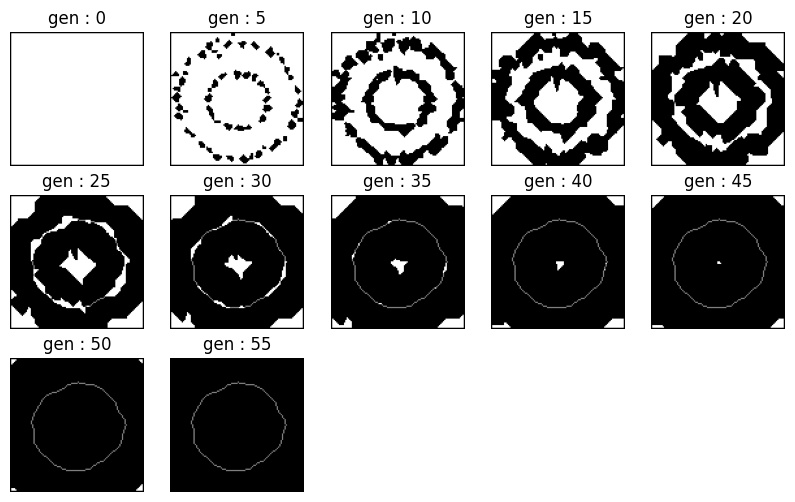

In [23]:
plot_level_custom(level_bin_array1, 2)

In [ ]:
plot_level_custom(level_bin_array2, 2)

In [ ]:
plot_level_custom(level_bin_array3, 2)

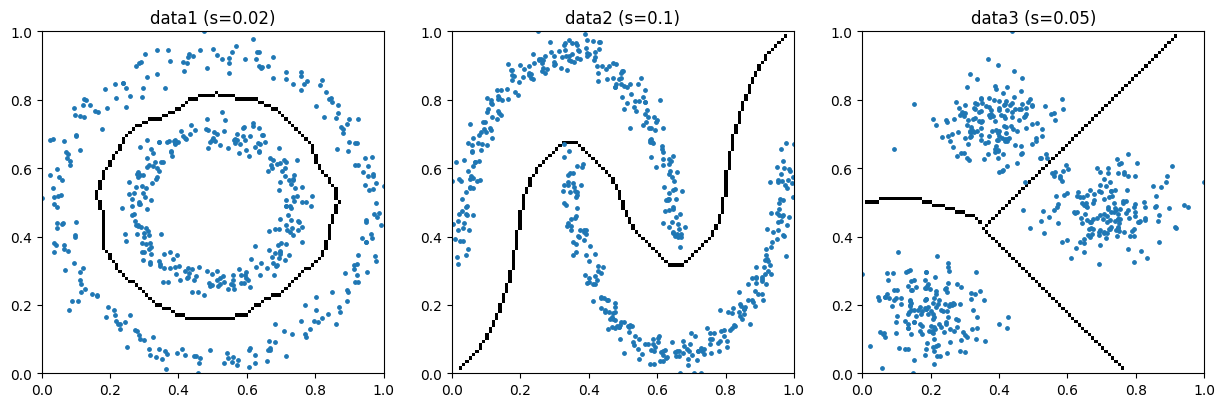

In [220]:
sub_list = [131, 132, 133]
s_det = [0.02, 0.1, 0.05]
title_list = [f'data1 (s={s_det[0]})', f'data2 (s={s_det[1]})', f'data3 (s={s_det[2]})']
edge_list = [edge1, edge2, edge3]

fig = plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(sub_list[i])
    data = data_list[i]
    edge = edge_list[i]
    s = s_det[i]
    title = title_list[i]

    edge_array = [[1 for _ in range(103)] for _ in range(103)]
    for i, j in edge:
        edge_array[i][j] = 0
    edge_array = np.array(edge_array)
    data = np.array(data)
    plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
    plt.scatter(data[:, 0], data[:, 1], s=6)
    plt.title(title)

plt.show()

In [ ]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
data = np.array(data)
plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.title("sigma=0.05, k=3")
plt.show()

(0.0, 30.0)

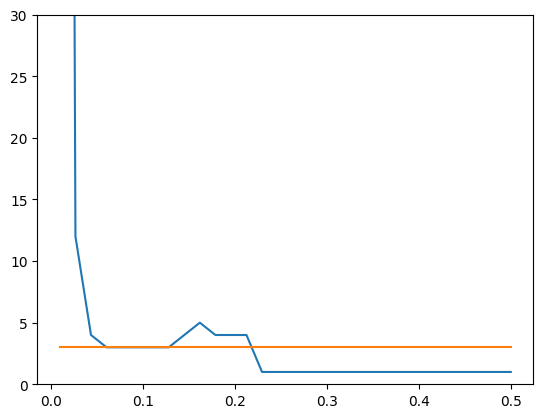

In [104]:
plt.plot(s_list, maxcnt_list)
plt.plot(s_list, np.array([3 for _ in range(30)]))
plt.ylim(0, 30)

In [106]:
level_bin_array, edge = simul_edge(data, lim=(1, 1), grid=400, ball=100, sigma=0.05, k=3)

[[62, 55], [63, 56], [61, 55], [64, 56], [60, 55], [65, 56], [59, 55], [66, 56], [58, 55], [67, 56], [57, 55], [68, 56], [56, 55], [55, 55], [69, 57], [54, 55], [53, 55], [70, 58], [53, 54], [70, 59], [53, 53], [53, 52], [71, 60], [52, 52], [71, 61], [52, 51], [71, 62], [52, 50], [52, 49], [72, 63], [51, 49], [52, 11], [72, 64], [51, 48], [52, 10], [52, 12], [50, 48], [52, 9], [52, 13], [73, 65], [49, 48], [52, 8], [52, 14], [73, 66], [48, 48], [52, 7], [47, 48], [52, 6], [74, 67], [46, 48], [52, 5], [45, 48], [52, 4], [75, 68], [44, 48], [51, 4], [76, 68], [43, 48], [51, 3], [42, 48], [51, 2], [77, 69], [41, 48], [51, 1], [78, 69], [40, 48], [79, 69], [39, 48], [80, 69], [38, 48], [81, 69], [37, 48], [82, 69], [36, 48], [83, 69], [35, 48], [84, 69], [34, 48], [85, 69], [33, 48], [86, 69], [32, 48], [87, 69], [35, 44], [36, 43], [37, 42], [38, 41], [88, 69], [34, 44], [39, 41], [47, 31], [48, 30], [89, 69], [34, 45], [90, 69], [33, 45], [40, 40], [48, 28], [49, 27], [91, 69], [33, 46],

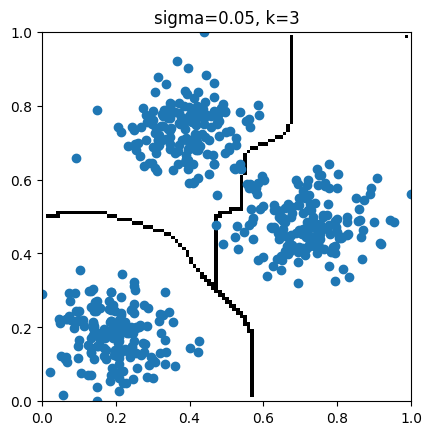

In [107]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
print(edge)
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
data = np.array(data)
plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
plt.scatter(data[:, 0], data[:, 1])
plt.title("sigma=0.05, k=3")
plt.show()

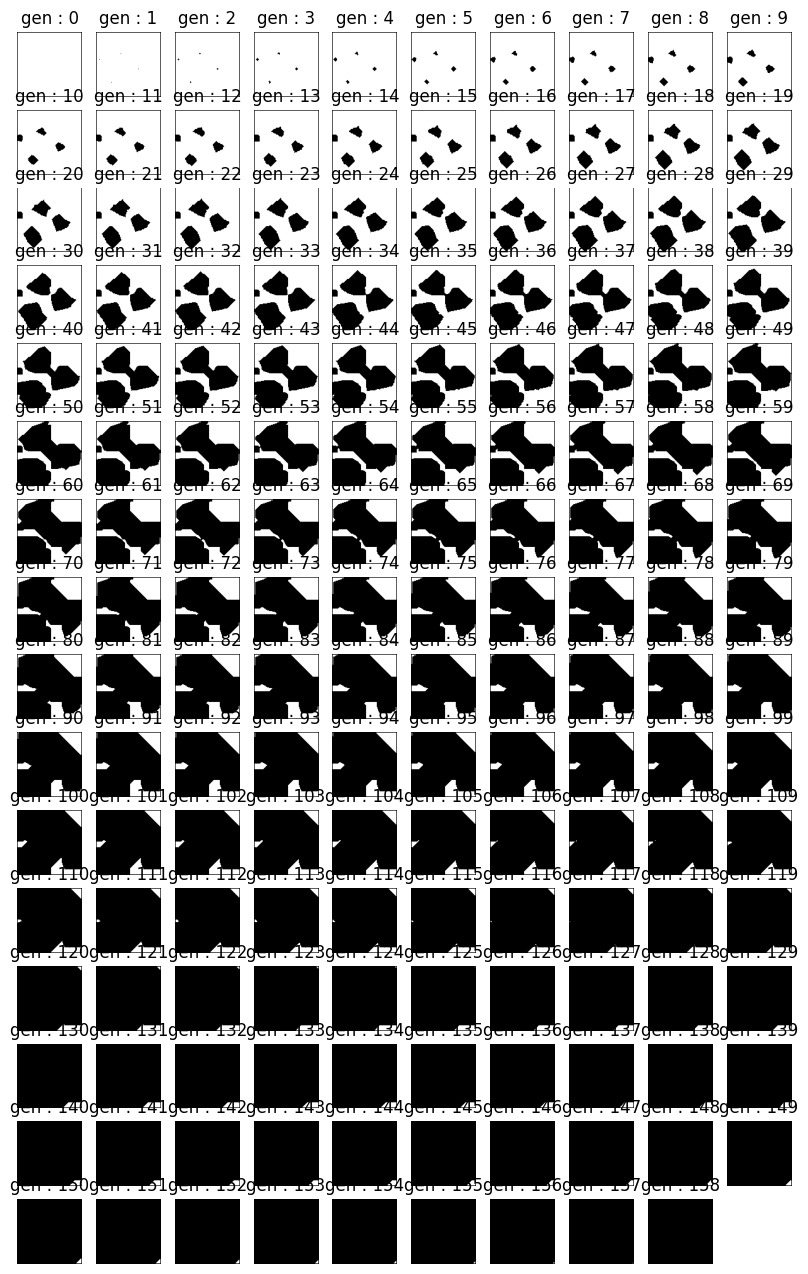

In [95]:
plot_level(level_bin_array, 1)

(0.0, 30.0)

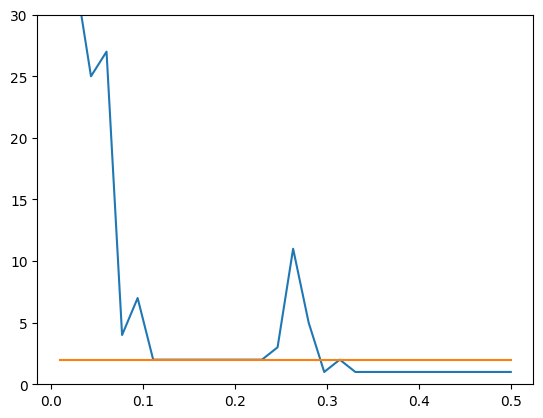

In [119]:
plt.plot(s_list, maxcnt_list)
plt.plot(s_list, np.array([2 for _ in range(30)]))
plt.ylim(0, 100)

In [165]:
level_bin_array, edge = simul_edge(data2, lim=(1, 1), grid=400, ball=100, sigma=0.1, k=2)

[[54, 50], [55, 49], [56, 49], [51, 51], [52, 50], [57, 49], [53, 50], [58, 48], [50, 51], [59, 48], [49, 51], [48, 51], [60, 47], [47, 51], [61, 25], [61, 47], [46, 51], [60, 25], [46, 52], [59, 25], [62, 26], [62, 46], [45, 52], [58, 25], [63, 26], [63, 46], [44, 52], [57, 25], [39, 76], [40, 77], [43, 52], [56, 25], [64, 45], [38, 76], [41, 77], [42, 52], [55, 25], [38, 75], [42, 53], [54, 25], [65, 44], [37, 75], [41, 53], [42, 78], [53, 25], [66, 44], [36, 75], [40, 53], [43, 78], [52, 25], [36, 74], [40, 54], [44, 78], [51, 25], [67, 43], [35, 74], [39, 54], [45, 78], [50, 25], [67, 42], [38, 54], [46, 78], [49, 25], [38, 55], [47, 78], [48, 25], [68, 41], [37, 55], [47, 25], [48, 78], [68, 40], [37, 56], [46, 25], [49, 78], [36, 56], [45, 25], [50, 78], [69, 39], [36, 57], [44, 25], [51, 78], [69, 38], [35, 57], [43, 25], [52, 78], [69, 37], [35, 58], [42, 25], [53, 78], [69, 36], [35, 59], [41, 25], [54, 78], [69, 35], [34, 59], [40, 25], [55, 78], [69, 34], [34, 60], [39, 25],

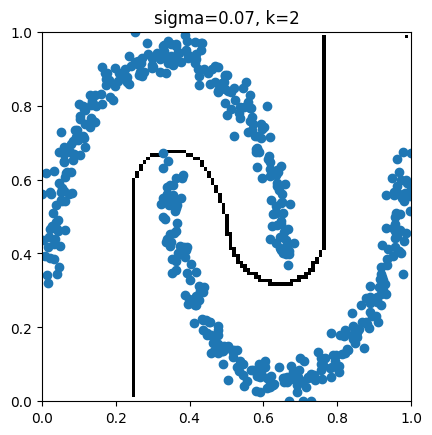

In [166]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
print(edge)
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
data = np.array(data)
plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
plt.scatter(data2[:, 0], data2[:, 1])
plt.title("sigma=0.07, k=2")
plt.show()

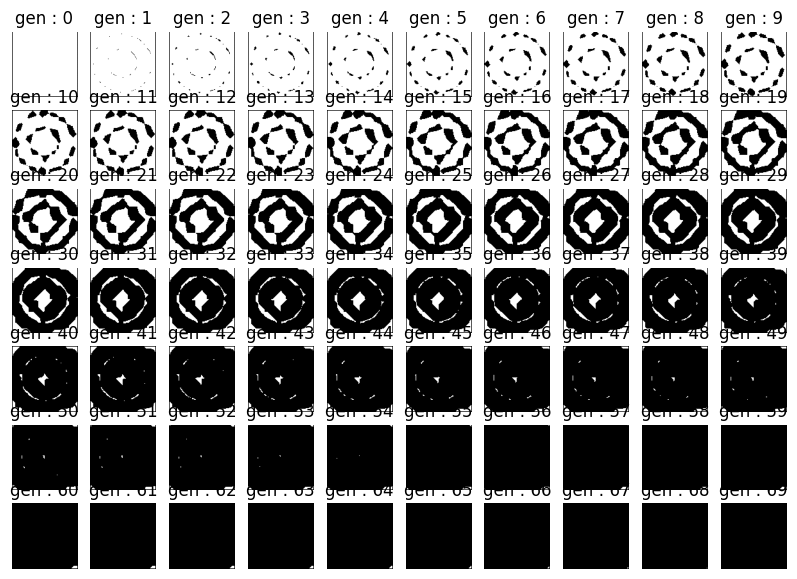

In [56]:
plot_level(level_bin_array, 1)

(0.0, 100.0)

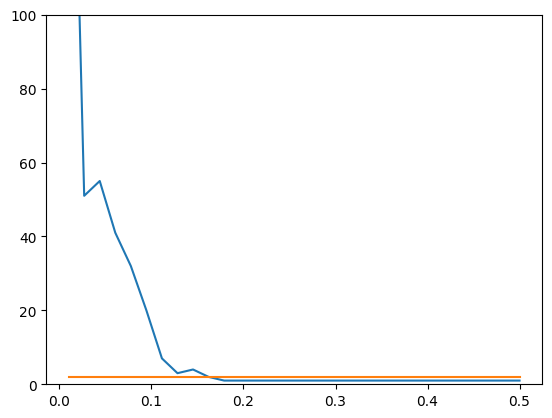

In [140]:
plt.plot(s_list, maxcnt_list)
plt.plot(s_list, np.array([2 for _ in range(30)]))
plt.ylim(0, 100)

In [154]:
level_bin_array, edge = simul_edge(data1, lim=(1, 1), grid=400, ball=100, sigma=0.02, k=2)

[[48, 18], [49, 17], [19, 63], [47, 18], [50, 17], [82, 64], [83, 55], [19, 62], [20, 65], [21, 66], [22, 67], [46, 18], [82, 63], [83, 54], [83, 56], [18, 62], [20, 64], [22, 68], [23, 69], [82, 62], [83, 53], [17, 58], [18, 61], [23, 70], [51, 17], [65, 82], [66, 81], [17, 61], [22, 32], [23, 31], [23, 71], [24, 72], [27, 27], [41, 18], [52, 17], [64, 82], [67, 81], [83, 57], [84, 52], [17, 60], [22, 33], [24, 31], [40, 18], [42, 18], [53, 17], [59, 85], [63, 82], [68, 81], [70, 24], [71, 25], [73, 27], [74, 28], [83, 58], [84, 51], [16, 49], [17, 59], [21, 33], [39, 18], [43, 18], [54, 17], [55, 88], [56, 87], [57, 86], [62, 82], [69, 24], [69, 81], [73, 26], [74, 29], [75, 30], [82, 58], [83, 51], [16, 48], [16, 50], [25, 30], [44, 18], [54, 88], [58, 86], [61, 82], [69, 80], [72, 26], [75, 31], [82, 59], [83, 50], [16, 47], [16, 51], [35, 20], [36, 19], [37, 18], [45, 18], [53, 88], [61, 83], [72, 25], [82, 60], [83, 49], [16, 46], [16, 52], [16, 57], [26, 29], [33, 21], [34, 20],

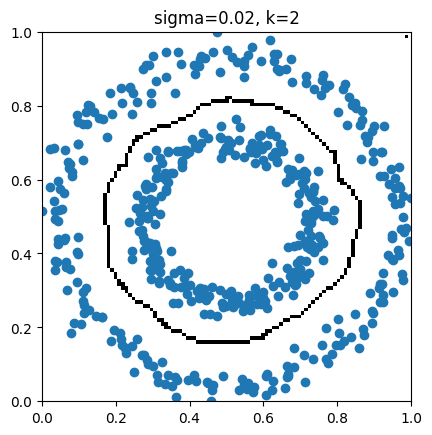

In [155]:
edge_array = [[1 for _ in range(103)] for _ in range(103)]
print(edge)
for i, j in edge:
    edge_array[i][j] = 0
edge_array = np.array(edge_array)
data = np.array(data)
plt.imshow(~edge_array[::-1], cmap='binary', extent=[0, 1, 0, 1])
plt.scatter(data1[:, 0], data1[:, 1])
plt.title("sigma=0.02, k=2")
plt.show()

(0.0, 100.0)

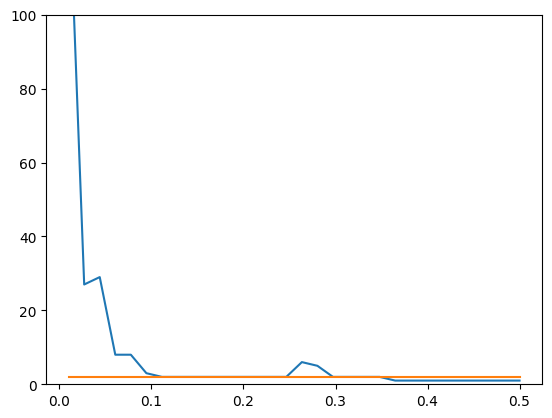

In [32]:
plt.plot(s_list, maxcnt_list)
plt.plot(s_list, np.array([2 for _ in range(30)]))
plt.ylim(0, 100)

(0.0, 10.0)

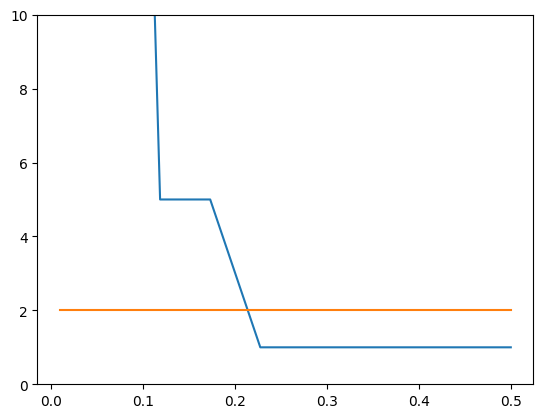

In [22]:
plt.plot(s_list, maxcnt_list)
plt.plot(s_list, np.array([2 for _ in range(10)]))
plt.ylim(0, 10)

In [3]:
li = np.linspace(0, 1, 100)
li.shape

(100,)